In [1]:
!apt-get update
!apt-get install openjdk-11-jdk -y
!pip install pyspark


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,940 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,197 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/u

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from pyspark.sql.functions import col, count, when

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.12/dist-packages/pyspark"


In [3]:
spark = SparkSession.builder \
    .appName("NYC Taxi Fare Prediction") \
    .getOrCreate()


In [4]:
# Set legacy parser for Spark 3+
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


# **## Load** **datasets**

In [5]:
# Parquet file path
df = spark.read.parquet("/content/yellow_tripdata_2024_combined.parquet")

In [6]:
#zone lookup CSV file path
zones_df = pd.read_csv("/content/taxi_zone_lookup.csv")  # columns: LocationID, Borough, Zone, service_zone

## **Initial EDA**

In [8]:
print("Parquet Schema:")
df.printSchema()
print("\nCSV Info:")
print(zones_df.info())


Parquet Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)


CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 

In [9]:
print("Parquet Shape:")
print(f"Row count: {df.count()}")
print(f"Columns: {len(df.columns)}")
print("CSV Shape:")
print("Row count:", len(zones_df))
print("Columns:", len(zones_df.columns))


Parquet Shape:
Row count: 26388179
Columns: 19
CSV Shape:
Row count: 265
Columns: 4


In [10]:
df.show(5, truncate=False)
zones_sdf = spark.createDataFrame(zones_df[['LocationID', 'Borough', 'Zone', 'service_zone']])
zones_sdf.show(5, truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|2       |2024-01-01 00:57:55 |2024-01-01 01:17:43  |1.0            |1.72         |1.0       |N                 |186         |79          |2           |17.7       |1.0  |0.5    |0.0      

In [11]:
print("\nMissing Value Counts in Parquet Data:")
for c in df.columns:
    null_count = df.select(count(when(col(c).isNull(), c)).alias("nulls")).collect()[0]["nulls"]
    print(f"{c}: {null_count}")

print("\nMissing Value Counts in CSV Data:")
for c in zones_df.columns:
    null_count = zones_sdf.filter(col(c).isNull()).count()
    print(f"{c}: {null_count}")


Missing Value Counts in Parquet Data:
VendorID: 0
tpep_pickup_datetime: 0
tpep_dropoff_datetime: 0
passenger_count: 2513641
trip_distance: 0
RatecodeID: 2513641
store_and_fwd_flag: 2513641
PULocationID: 0
DOLocationID: 0
payment_type: 0
fare_amount: 0
extra: 0
mta_tax: 0
tip_amount: 0
tolls_amount: 0
improvement_surcharge: 0
total_amount: 0
congestion_surcharge: 2513641
Airport_fee: 2513641

Missing Value Counts in CSV Data:
LocationID: 0
Borough: 0
Zone: 0
service_zone: 0


In [12]:
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicate_count = total_rows - unique_rows
print("\nDuplicate Analysis:")
print("Total Rows:", total_rows)
print("Unique Rows:", unique_rows)
print("Duplicate Rows:", duplicate_count)


Duplicate Analysis:
Total Rows: 26388179
Unique Rows: 26388177
Duplicate Rows: 2


In [13]:
# EDA: Summary Statistics for Continuous Variables
print("\nSummary Statistics for Key Continuous Variables:")
df.describe(['trip_distance', 'fare_amount', 'passenger_count', 'total_amount','tip_amount']).show()


Summary Statistics for Key Continuous Variables:
+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|   passenger_count|      total_amount|        tip_amount|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          26388179|          26388179|          23874538|          26388179|          26388179|
|   mean|4.7794086071647905|19.056705122378524|1.3384668637357506|27.606065162258666|3.2686567830266227|
| stddev|367.38173194825515| 68.56927717907152|0.8320588435842922| 70.03062001154993|4.0478649498260735|
|    min|               0.0|           -2261.2|               0.0|          -2265.45|            -300.0|
|    max|         327025.19|         334076.32|               9.0|          334145.3|            999.99|
+-------+------------------+------------------+------------------+------------------+------------------+



In [ ]:
# EDA: Outlier Detection Using IQR Method
def detect_outliers(df, column):
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)  # 0.05 relative error
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    return lower_bound, upper_bound, outlier_count

# Detect outliers for each variable
variables = ['trip_distance', 'fare_amount', 'passenger_count', 'tip_amount']
outlier_stats = {}

for var in variables:
    lower, upper, count = detect_outliers(df, var)
    outlier_stats[var] = {'lower_bound': lower, 'upper_bound': upper, 'outlier_count': count}
    print(f"\nOutlier Detection for {var}:")
    print(f"Q1: {df.approxQuantile(var, [0.25], 0.05)[0]:.2f}, Q3: {df.approxQuantile(var, [0.75], 0.05)[0]:.2f}")
    print(f"IQR: {upper - lower:.2f}")
    print(f"Outlier Range: < {lower:.2f} or > {upper:.2f}")
    print(f"Number of outliers: {count}")


Outlier Detection for trip_distance:
Q1: 1.00, Q3: 3.10
IQR: 8.40
Outlier Range: < -2.15 or > 6.25
Number of outliers: 3648948

Outlier Detection for fare_amount:
Q1: 9.30, Q3: 21.90
IQR: 50.40
Outlier Range: < -9.60 or > 40.80
Number of outliers: 2778474

Outlier Detection for passenger_count:
Q1: 1.00, Q3: 2.00
IQR: 4.00
Outlier Range: < -0.50 or > 3.50
Number of outliers: 901598

Outlier Detection for tip_amount:
Q1: 1.00, Q3: 4.05
IQR: 12.20
Outlier Range: < -3.57 or > 8.62
Number of outliers: 2054684


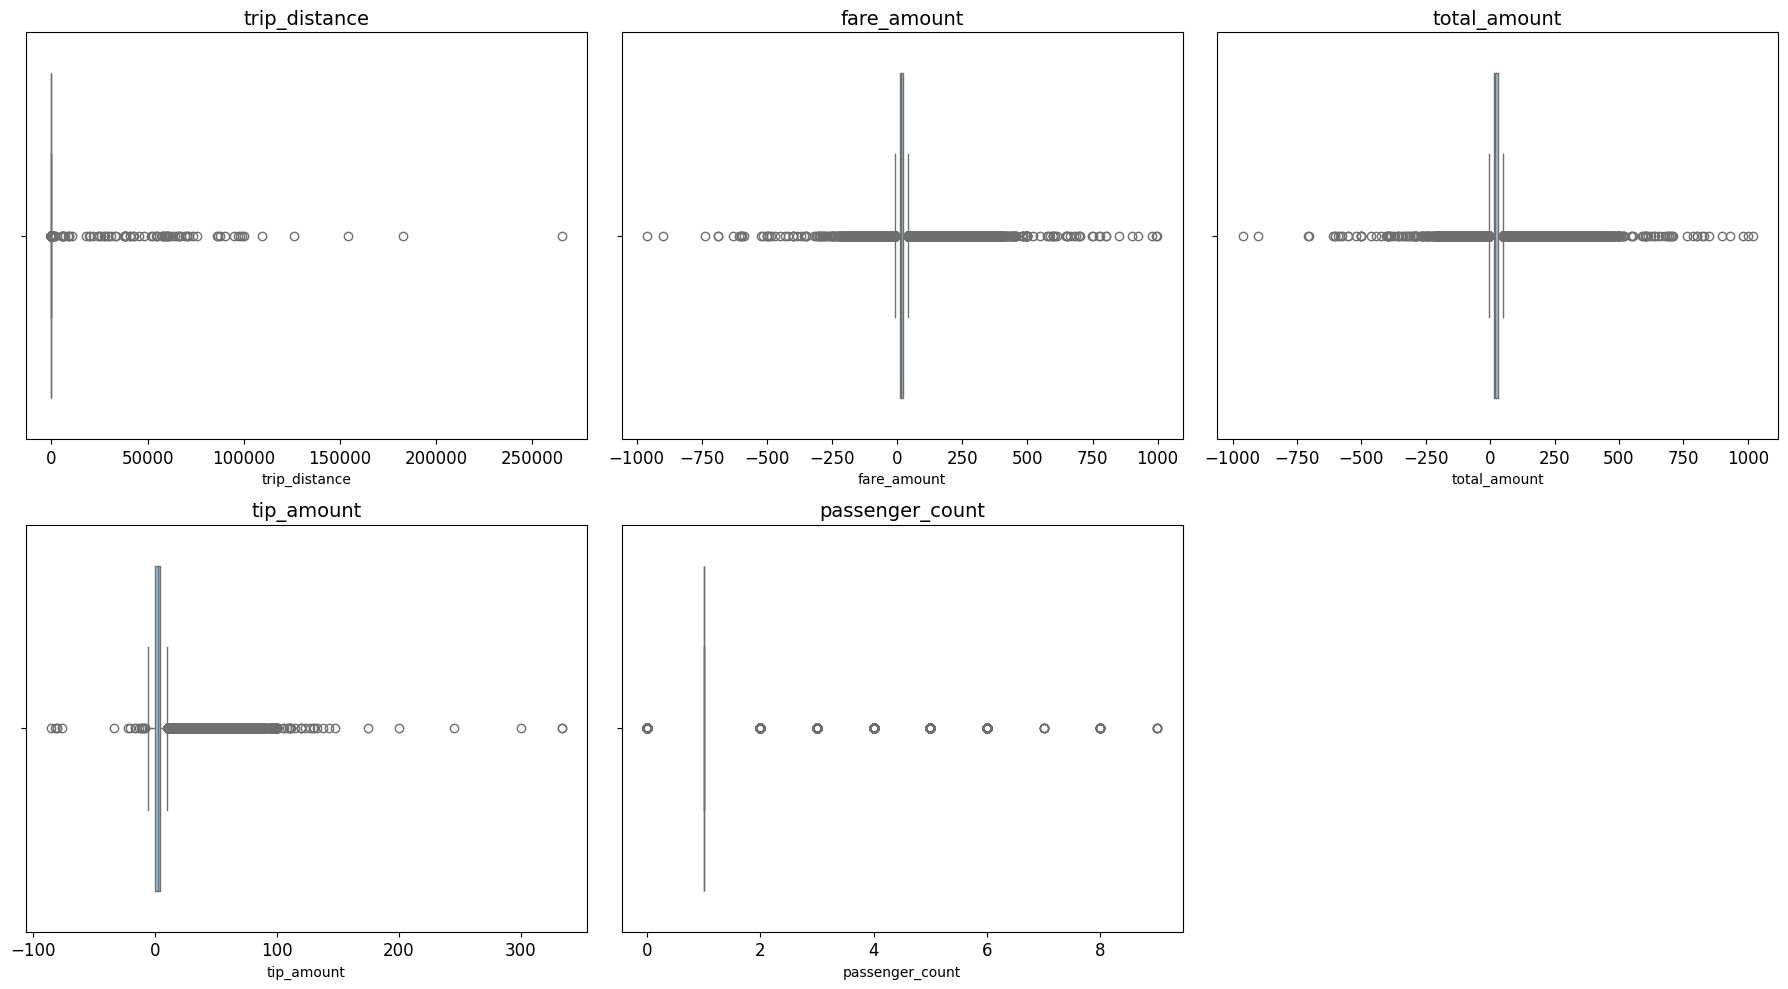

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Convert to Pandas (or sample if large)
df_pd = df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Select relevant features
relevant_cols = ["trip_distance", "fare_amount", "total_amount", "tip_amount", "passenger_count"]

# Determine layout: 3 columns per row
plots_per_row = 3
n_rows = math.ceil(len(relevant_cols) / plots_per_row)

# Create figure
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(plots_per_row * 6, n_rows * 5))
axes = axes.flatten()

# Plot each relevant feature
for i, col in enumerate(relevant_cols):
    sns.boxplot(x=df_pd[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].tick_params(axis='x', labelsize=12)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("relevant_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
rows_outside_2024 = df.filter(
    (year(col("tpep_pickup_datetime")) != 2024) |
    (year(col("tpep_dropoff_datetime")) != 2024)
).count()

print(f"Rows with either pickup or dropoff date NOT in 2024: {rows_outside_2024}")


Rows with either pickup or dropoff date NOT in 2024: 41


## **pre processing**

Data integration

In [7]:
zones_sdf = spark.createDataFrame(zones_df[['LocationID','Borough']])

In [8]:
# Pickup borough
df = df.join(zones_sdf.withColumnRenamed("LocationID","PULocationID")
                     .withColumnRenamed("Borough","pickup_borough"),
             on="PULocationID", how="left")

# Dropoff borough
df = df.join(zones_sdf.withColumnRenamed("LocationID","DOLocationID")
                     .withColumnRenamed("Borough","dropoff_borough"),
             on="DOLocationID", how="left")


In [ ]:
print("Updated Columns:")
for col_name in df.columns:
    print(col_name)


Updated Columns:
DOLocationID
PULocationID
VendorID
tpep_pickup_datetime
tpep_dropoff_datetime
passenger_count
trip_distance
RatecodeID
store_and_fwd_flag
payment_type
fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
Airport_fee
pickup_borough
dropoff_borough


Remove duplicates

In [24]:
total_rows = df.count()
df = df.dropDuplicates()
print(f"Removed {total_rows - df.count()} duplicate rows")


Removed 2 duplicate rows


Handle missing values

In [10]:
from pyspark.sql.functions import col, coalesce, lit

# Remove rows with missing passenger_count
df = df.filter(col("passenger_count").isNotNull())

# Replace nulls in optional numeric columns with 0
df = df.withColumn("Airport_fee", coalesce(col("Airport_fee"), lit(0)))
df = df.withColumn("congestion_surcharge", coalesce(col("congestion_surcharge"), lit(0)))

# Drop columns that are mostly missing and not needed
cols_to_drop = ["store_and_fwd_flag", "RatecodeID"]
df = df.drop(*cols_to_drop)


Invalid values filter

In [11]:
from pyspark.sql.functions import year, col


# Keep only trips in 2024
df = df.filter(
    (year(col("tpep_pickup_datetime")) == 2024) &
    (year(col("tpep_dropoff_datetime")) == 2024)
)


In [ ]:
from pyspark.sql.functions import year, col

# Store original row count
original_count = df.count()

# Keep only trips in 2024
df = df.filter(
    (year(col("tpep_pickup_datetime")) == 2024) &
    (year(col("tpep_dropoff_datetime")) == 2024)
)

# Calculate removed rows
removed_rows = original_count - df.count()
print(f"Number of rows after keeping only 2024 trips: {df.count()}")
print(f"Number of rows removed: {removed_rows}")


Number of rows after keeping only 2024 trips: 23874495
Number of rows removed: 41


In [ ]:
from pyspark.sql.functions import min, max, col

# Find min and max for pickup and dropoff
date_range = df.agg(
    min(col("tpep_pickup_datetime")).alias("earliest_pickup"),
    max(col("tpep_pickup_datetime")).alias("latest_pickup"),
    min(col("tpep_dropoff_datetime")).alias("earliest_dropoff"),
    max(col("tpep_dropoff_datetime")).alias("latest_dropoff")
)

date_range.show(truncate=False)


+-------------------+-------------------+-------------------+-------------------+
|earliest_pickup    |latest_pickup      |earliest_dropoff   |latest_dropoff     |
+-------------------+-------------------+-------------------+-------------------+
|2024-01-01 00:00:00|2024-09-10 12:27:29|2024-01-01 00:02:42|2024-09-10 19:45:57|
+-------------------+-------------------+-------------------+-------------------+



In [12]:
# Remove trips with zero or negative trip_distance
df = df.filter(col("trip_distance") > 0)

# Remove trips with zero or negative fare_amount
df = df.filter(col("fare_amount") > 0)

# Remove trips with passenger_count = 0
df = df.filter(col("passenger_count") > 0)


In [ ]:
print("Number of rows after cleaning:", df.count())
df.printSchema()


Number of rows after cleaning: 22954112
root
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = false)
 |-- Airport_fee: double (nullable = false)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)



outliers handling

In [13]:
from pyspark.sql.functions import col
def remove_outliers_iqr(df, column):
    # Approximate quantiles for big data
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)  # 5% relative error
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_filtered = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    print(f"{column} - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Rows before: {df.count()}, Rows after: {df_filtered.count()}")

    return df_filtered


In [14]:
# Remove trip_distance outliers
df = remove_outliers_iqr(df, "trip_distance")

# Remove fare_amount outliers
df = remove_outliers_iqr(df, "fare_amount")


trip_distance - Q1: 0.93, Q3: 3.06, IQR: 2.13
Lower bound: -2.2649999999999997, Upper bound: 6.255
Rows before: 22954112, Rows after: 19654327
fare_amount - Q1: 9.3, Q3: 17.0, IQR: 7.699999999999999
Lower bound: -2.2499999999999982, Upper bound: 28.549999999999997
Rows before: 19654327, Rows after: 19025341


In [15]:
from pyspark.sql.functions import col

df = df.filter(col("fare_amount") <= 1000)


Data type conversion

In [16]:
from pyspark.sql.functions import col, to_timestamp

# Ensure pickup and dropoff are timestamps
df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"))) \
       .withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

# Ensure numeric fields are correct types
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount",
                "extra", "mta_tax", "tolls_amount", "improvement_surcharge",
                "congestion_surcharge", "Airport_fee"]

for c in numeric_cols:
    df = df.withColumn(c, col(c).cast("double"))

# passenger_count as integer
df = df.withColumn("passenger_count", col("passenger_count").cast("integer"))


Feature engineering

In [17]:
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, round
from pyspark.ml.feature import StringIndexer

# Convert datetime columns
df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"))) \
       .withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

# Derive trip_duration in minutes
df = df.withColumn("trip_duration",
                   round((unix_timestamp(col("tpep_dropoff_datetime")) -
                          unix_timestamp(col("tpep_pickup_datetime"))) / 60, 2))




In [18]:
# Extract pickup hour and day of week
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
       .withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime"))

# Rush hour flag (7-10am, 4-7pm)
df = df.withColumn("rush_hour", when(
    (col("pickup_hour").between(7,10)) | (col("pickup_hour").between(16,19)), 1
).otherwise(0))


## **Advanced EDA**

Original feature distribution

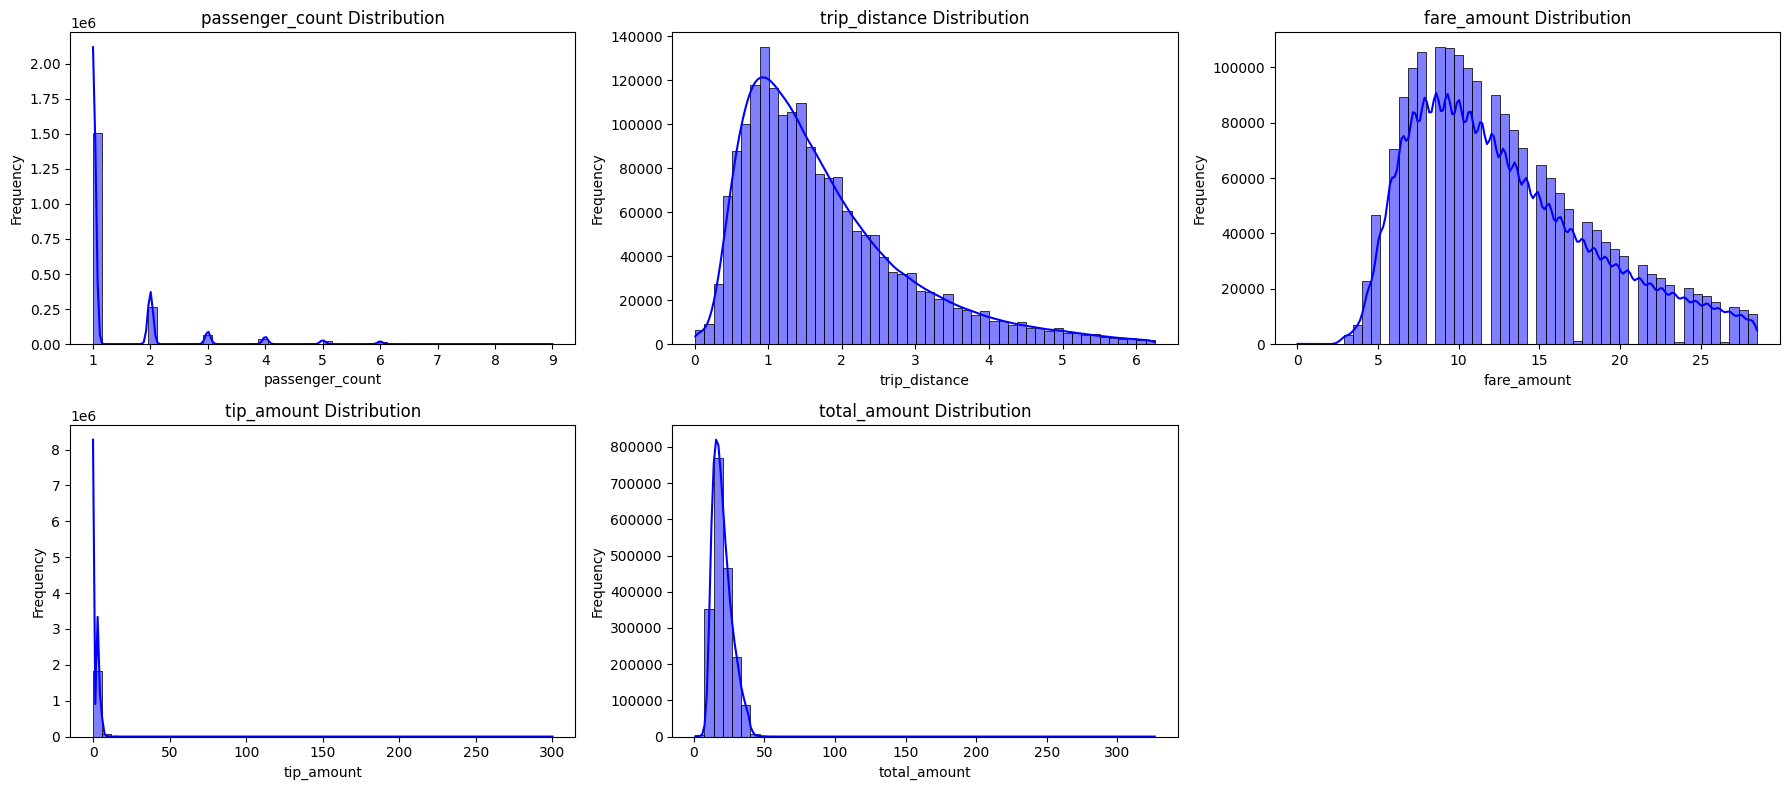

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 10% of the data for plotting
df_sample = df.sample(False, 0.1, seed=42).toPandas()

# Numeric features to plot
numeric_features = ["passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount"]

# Define grid layout
n_cols = 3  # 3 plots per row
n_rows = -(-len(numeric_features) // n_cols)  # Ceiling division

# Create figure
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

# Plot each feature
for i, col in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df_sample[col], bins=50, kde=True, color="blue")
    plt.title(f"{col} Distribution", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("feature_distributions.png", dpi=300, bbox_inches='tight')  # Save for report
plt.show()


Trip distance vs Fare amount

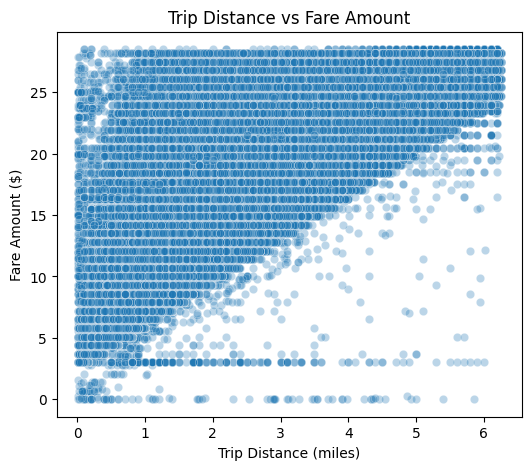

In [35]:
# Sample data for plotting (10% for performance)
df_sample = df.sample(False, 0.1, seed=42).toPandas()
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_sample, x="trip_distance", y="fare_amount", alpha=0.3)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.show()


Distribution of payment method

/tmp/ipython-input-2132046461.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, x="payment_type", order=df_sample["payment_type"].value_counts().index, palette="Set2")


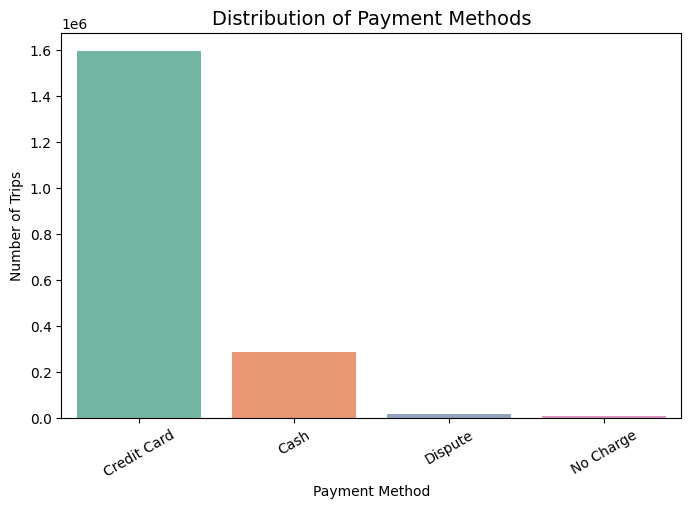

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping for payment_type
payment_mapping = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

# Convert sample to Pandas for visualization
df_sample = df.sample(False, 0.1, seed=42).toPandas()

# Map payment_type
df_sample["payment_type"] = df_sample["payment_type"].map(payment_mapping)

# Countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sample, x="payment_type", order=df_sample["payment_type"].value_counts().index, palette="Set2")
plt.title("Distribution of Payment Methods", fontsize=14)
plt.xlabel("Payment Method")
plt.ylabel("Number of Trips")
plt.xticks(rotation=30)
plt.show()


Trips by pickup hour

/tmp/ipython-input-3094577986.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, x="pickup_hour", palette="Blues")


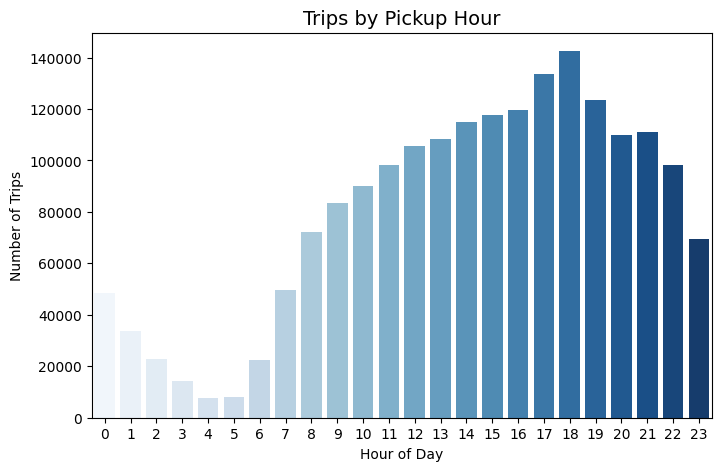

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample 10% for plotting
df_sample = df.sample(False, 0.1, seed=42).toPandas()

# Convert pickup datetime if needed
df_sample["tpep_pickup_datetime"] = pd.to_datetime(df_sample["tpep_pickup_datetime"])

# Extract time features
df_sample["pickup_hour"] = df_sample["tpep_pickup_datetime"].dt.hour
df_sample["pickup_day"] = df_sample["tpep_pickup_datetime"].dt.day_name()
df_sample["pickup_month"] = df_sample["tpep_pickup_datetime"].dt.month_name()
# 2️⃣ Trips by pickup hour
plt.figure(figsize=(8,5))
sns.countplot(data=df_sample, x="pickup_hour", palette="Blues")
plt.title("Trips by Pickup Hour", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.savefig("trips_by_hour.png", dpi=300, bbox_inches='tight')
plt.show()

Trips by pickup day of week

/tmp/ipython-input-3392275425.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, x="pickup_day", order=order_days, palette="viridis")


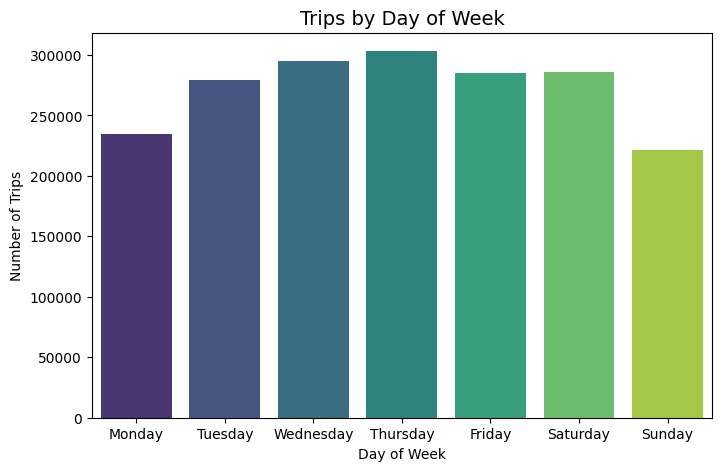

In [52]:
# 3️⃣ Trips by pickup day of week
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(8,5))
sns.countplot(data=df_sample, x="pickup_day", order=order_days, palette="viridis")
plt.title("Trips by Day of Week", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.savefig("trips_by_day.png", dpi=300, bbox_inches='tight')
plt.show()

Trips by pickup month

/tmp/ipython-input-4123568071.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, x="pickup_month", order=order_months, palette="magma")


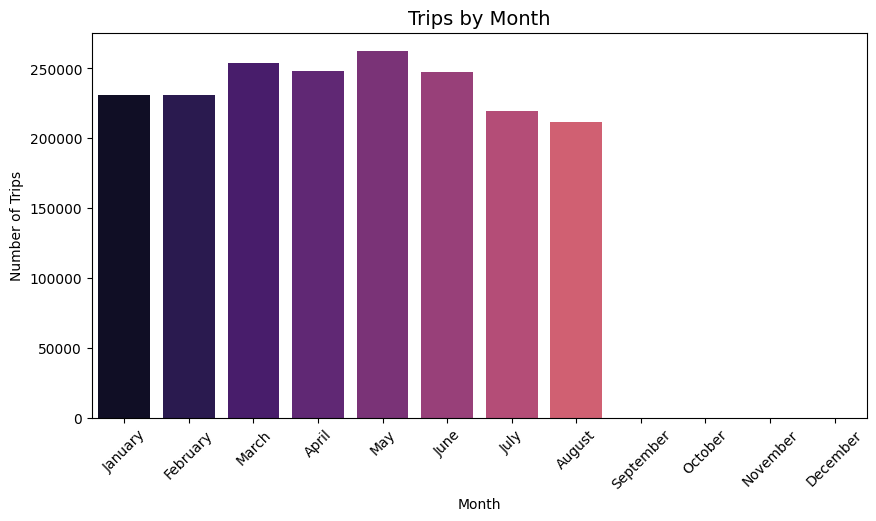

In [53]:
# 4️⃣ Trips by pickup month
order_months = ["January","February","March","April","May","June",
                "July","August","September","October","November","December"]
plt.figure(figsize=(10,5))
sns.countplot(data=df_sample, x="pickup_month", order=order_months, palette="magma")
plt.title("Trips by Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.savefig("trips_by_month.png", dpi=300, bbox_inches='tight')
plt.show()

Most popular pickup locations

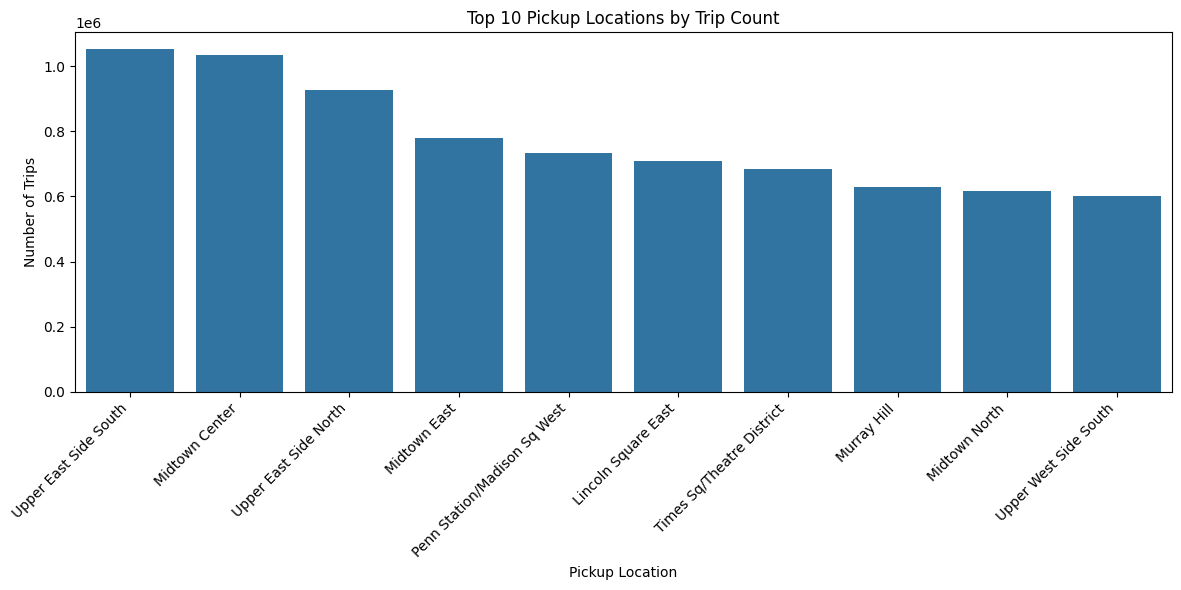

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
zones_sdf = spark.createDataFrame(zones_df[['LocationID', 'Zone']]).withColumnRenamed('LocationID', 'PULocationID')

# Join df with zones_sdf to map PULocationID to Zone
df_with_zones = df.join(zones_sdf, 'PULocationID', 'left')

# EDA: Geographic Distribution - Top 10 Pickup Locations by Trip Count (with Zone names)
pu_loc_counts = df_with_zones.groupBy('Zone').count().orderBy('count', ascending=False).filter(col('Zone').isNotNull()).limit(10).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=pu_loc_counts, x='Zone', y='count')
plt.title('Top 10 Pickup Locations by Trip Count')
plt.xlabel('Pickup Location')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

Correlation heatmap

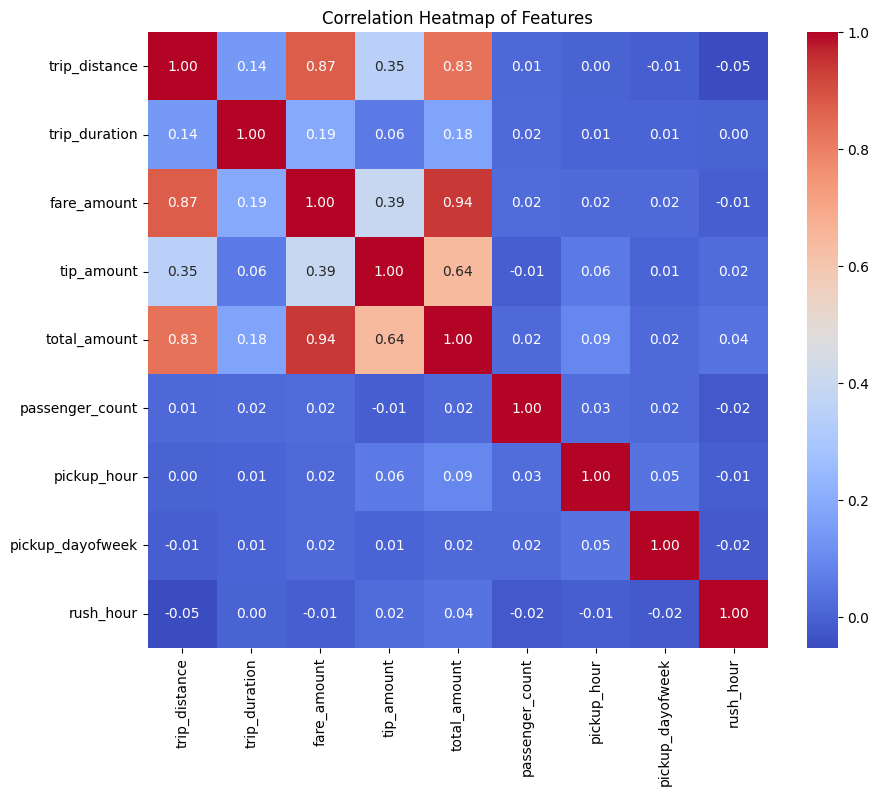

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns to check correlation
corr_cols = [
    "trip_distance", "trip_duration", "fare_amount",
    "tip_amount", "total_amount", "passenger_count",
    "pickup_hour", "pickup_dayofweek", "rush_hour"
]

# Create correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_sample[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Features")

# Save the heatmap as an image (PNG format)
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


Encode Categorical Features

In [19]:
from pyspark.ml.feature import StringIndexer

indexer_pickup = StringIndexer(inputCol="pickup_borough", outputCol="pickup_borough_index", handleInvalid="keep")
indexer_dropoff = StringIndexer(inputCol="dropoff_borough", outputCol="dropoff_borough_index", handleInvalid="keep")
indexer_pay = StringIndexer(inputCol="payment_type", outputCol="payment_type_index", handleInvalid="keep")

# Fit and transform the dataframe
df = indexer_pickup.fit(df).transform(df)
df = indexer_dropoff.fit(df).transform(df)
df = indexer_pay.fit(df).transform(df)


Sample dataset

In [20]:
# Sample Dataset for Faster Training
sample_df = df.sample(False, 0.1, seed=42)  # 10% sample
train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=42)


Assemble Features

In [21]:
#Assemble Features
feature_cols = [
    "trip_distance", "trip_duration", "passenger_count",
    "pickup_hour", "pickup_dayofweek", "rush_hour",
    "pickup_borough_index", "dropoff_borough_index", "payment_type_index"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

## **GBT model**

GBT Model Implementation

In [22]:
#  Define GBT Model
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="fare_amount", maxIter=20, maxDepth=5)

# Build Pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model= pipeline.fit(train_df)

 Make Predictions

In [23]:
# 6️⃣ Make Predictions
predictions = model.transform(test_df)
predictions.select("fare_amount", "prediction", "trip_distance", "trip_duration").show(10)

+-----------+------------------+-------------+-------------+
|fare_amount|        prediction|trip_distance|trip_duration|
+-----------+------------------+-------------+-------------+
|       19.1| 18.41262617871121|          3.8|        12.28|
|       26.8|26.146371771800617|          4.6|        23.55|
|       14.2|13.836263475418122|         1.84|        14.28|
|       26.8| 24.25618914349959|         3.23|        30.33|
|       12.1|13.875246512086083|          2.1|        13.27|
|       18.4|19.567532708707922|         2.64|         20.5|
|       19.8|19.725867682663893|         3.04|         19.9|
|        7.2| 8.196919435397984|          0.9|         6.38|
|        5.1|  5.34126271133811|          0.3|          3.1|
|        7.2| 6.982648460668667|          0.6|         6.32|
+-----------+------------------+-------------+-------------+
only showing top 10 rows



In [ ]:
# 7️⃣ Evaluate Model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 0.95
MAE: 0.58
R²: 0.972


## **RandomForest model**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# Define feature columns
feature_cols = [
    "trip_distance", "trip_duration", "passenger_count",
    "pickup_hour", "pickup_dayofweek", "pickup_borough_index",
    "dropoff_borough_index", "payment_type_index"
]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="fare_amount",
                           maxDepth=10, numTrees=50, seed=42)

# Build pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Train model
model_rf = pipeline_rf.fit(train_df)

# Make predictions
predictions_rf = model_rf.transform(test_df)

# Show sample predictions
predictions_rf.select("fare_amount", "prediction", "trip_distance", "trip_duration").show(10)


+-----------+------------------+-------------+-------------+
|fare_amount|        prediction|trip_distance|trip_duration|
+-----------+------------------+-------------+-------------+
|        3.7| 4.159730131168256|         0.16|         1.97|
|       19.1|18.216541305321055|         4.13|        10.53|
|       27.5|25.970567974765153|          5.0|        32.67|
|       22.6|23.614138042712874|          4.1|        21.78|
|       25.4|25.294347469073553|         3.89|        24.42|
|       12.1| 14.50495744829899|          2.1|        13.27|
|       16.3|16.788444553870246|         1.94|        17.88|
|       23.3|22.526430088716573|         3.01|        25.22|
|       12.1| 11.93909471306099|          1.4|        12.13|
|        5.8|5.8833028863053105|          0.7|         3.38|
+-----------+------------------+-------------+-------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="mae"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="r2"
)

# Evaluate predictions
rmse = evaluator_rmse.evaluate(predictions_rf)
mae = evaluator_mae.evaluate(predictions_rf)
r2 = evaluator_r2.evaluate(predictions_rf)

# Print evaluation results
print(f"Random Forest Regressor Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")


Random Forest Regressor Evaluation:
RMSE: 0.91
MAE: 0.52
R²: 0.974


# **Linear Regression model**

In [ ]:
from pyspark.ml.regression import LinearRegression

# Define Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount", maxIter=100, regParam=0.1)

# Build pipeline
pipeline_lr = Pipeline(stages=[assembler, lr])

# Train model
model_lr = pipeline_lr.fit(train_df)

# Make predictions
predictions_lr = model_lr.transform(test_df)

# Show sample predictions
predictions_lr.select("fare_amount", "prediction", "trip_distance", "trip_duration").show(10)


+-----------+------------------+-------------+-------------+
|fare_amount|        prediction|trip_distance|trip_duration|
+-----------+------------------+-------------+-------------+
|        3.7| 5.665454295238256|         0.16|         1.97|
|       19.1| 22.54375994259902|         4.13|        10.53|
|       27.5| 26.74726531795564|          5.0|        32.67|
|       22.6| 22.92977332833782|          4.1|        21.78|
|       17.0|20.903203074115112|         3.65|         9.35|
|       24.7|15.898032532972806|         2.38|        30.53|
|       18.4|16.583802683996183|         2.59|        19.58|
|       19.1|17.245309971836857|         2.77|        19.97|
|        8.6| 9.733248734084397|          1.0|         7.03|
|        5.1|6.6884159352942625|          0.3|          3.1|
+-----------+------------------+-------------+-------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
evaluator_rmse = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="rmse"
)
evaluator_mae = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="mae"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="fare_amount", predictionCol="prediction", metricName="r2"
)

# Calculate metrics
rmse = evaluator_rmse.evaluate(predictions_lr)
mae = evaluator_mae.evaluate(predictions_lr)
r2 = evaluator_r2.evaluate(predictions_lr)

# Print results
print(f"Linear Regression Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Linear Regression Model Performance:
RMSE: 2.7142
MAE: 1.9921
R²: 0.7659


Feature importance

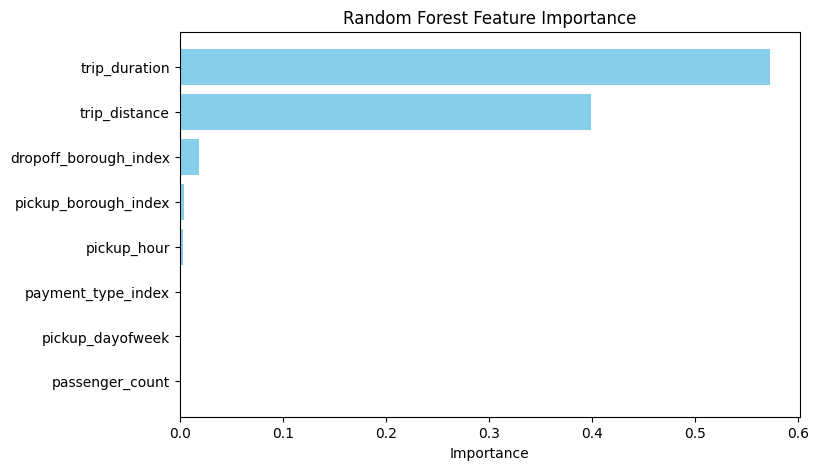

In [25]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt

# feature columns
feature_cols = ["trip_distance", "trip_duration", "passenger_count",
    "pickup_hour", "pickup_dayofweek", "pickup_borough_index",
    "dropoff_borough_index", "payment_type_index"]

# Your VectorAssembler used in pipeline
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Random Forest model
rf_model = RandomForestRegressor(featuresCol="features", labelCol="fare_amount", numTrees=50, maxDepth=10)
pipeline_rf = Pipeline(stages=[assembler, rf_model])
model_rf = pipeline_rf.fit(train_df)

# Get feature importances
rf_feature_importances = model_rf.stages[-1].featureImportances

# Convert to pandas for visualization
fi_pd = pd.DataFrame(list(zip(feature_cols, rf_feature_importances.toArray())), columns=["feature", "importance"])
fi_pd = fi_pd.sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(fi_pd['feature'], fi_pd['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [30]:
# Print the feature importance table
print(fi_pd)

                 feature  importance
1          trip_duration    0.573163
0          trip_distance    0.399359
6  dropoff_borough_index    0.019115
5   pickup_borough_index    0.003670
3            pickup_hour    0.003180
7     payment_type_index    0.000812
4       pickup_dayofweek    0.000590
2        passenger_count    0.000111
